# Naive Bayes Classifier - Census Dataset

### 1. Importing Data and Python Packages

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing

# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style="dark")

# split into train and test, do grid search for hyperparameter optimization and
# do cross validation with stratified data
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV

# data scaling
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector
# test data
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from sklearn.pipeline import make_pipeline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB

from warnings import filterwarnings 
filterwarnings('ignore')

In [3]:
# Import data into a pandas dataframe
df = pd.read_csv(r'E:/IITm/Sem 7/Data Analytics Lab/Assignment 3 Oct 17th/adult_csv.csv')
df.head()

,Index,Age,Workclass,fnlwgt,Education,Edu years,marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours per week,Native country,Income
0,1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df.shape

(32561, 16)

In [5]:
df.describe()

,Index,Age,fnlwgt,Edu years,Capital-gain,Capital-loss,Hours per week
count,32561.000000,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,16281.000000,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,9399.695394,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,1.000000,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,8141.000000,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,16281.000000,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,24421.000000,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,32561.000000,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


There is both continuous and categorical data. We will study all the 15 (excluding index) variables.

In [6]:
#Stripping unnecessary white spaces in the columns of the dataframe
for i in df.columns:
    if df[i].dtype == object:
        df[i] = df[i].str.strip()

### 2 Data Exploration

### 2.1 Target Variable
#### Income

In [7]:
#Initial copy of the dataframe before any cleaning
dat1 = df.copy()

In [8]:
# Income is the target variable. 
df['Income'].unique() # show unique values

array(['<=50K', '>50K'], dtype=object)

We can replace this variable with a categorical variable which is 1 for '>50K' and 0 for '<=50K'

In [11]:
df['Income'].replace(['<=50K','>50K'],[0,1], inplace=True) # replace for 0 and 1
df['Income'].value_counts() # show number of samples for each value

0    24720
1     7841
Name: Income, dtype: int64

In [12]:
# Percentage of people that has >50k:
np.mean(df['Income'])

0.2408095574460244

Since it is an imbalanced target variable, stratification will be used when splitting the dataset into test and train sets when doing cross validation.

### 2.2 Categorical Variables

#### Workclass

In [13]:
df['Workclass'].value_counts() 

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: Workclass, dtype: int64

There are 1836 missing values

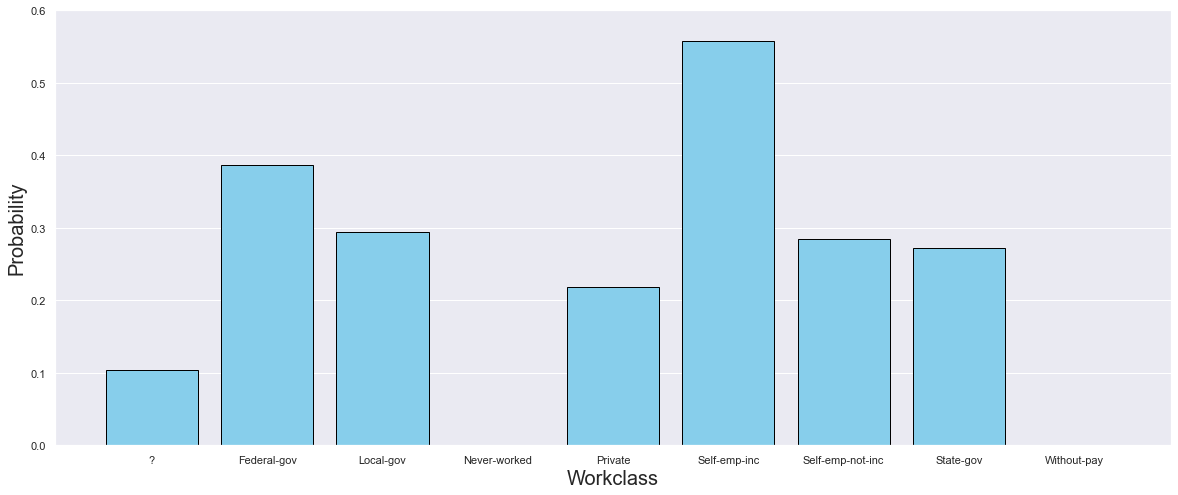

In [14]:
# probability of belonging to the group with the highest income
workclass_income = df.groupby('Workclass')['Income'].mean() # there is correlation as spected

plt.rcParams['axes.axisbelow'] = True # grid behind graphs bars
plt.figure(figsize=(20, 8))
plt.ylim(0,0.6) # values from 0 to 1 as there are probabilities
plt.bar(workclass_income.index.astype(str), workclass_income,
       color = 'SkyBlue' , edgecolor='black' )
plt.ylabel('Probability', size=20)
plt.xlabel('Workclass', size=20)
plt.grid(axis='y')

Probabilities are as expected

#### Education

In [15]:
df['Education'].unique() 

array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
       'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school',
       '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], dtype=object)

There are no null values

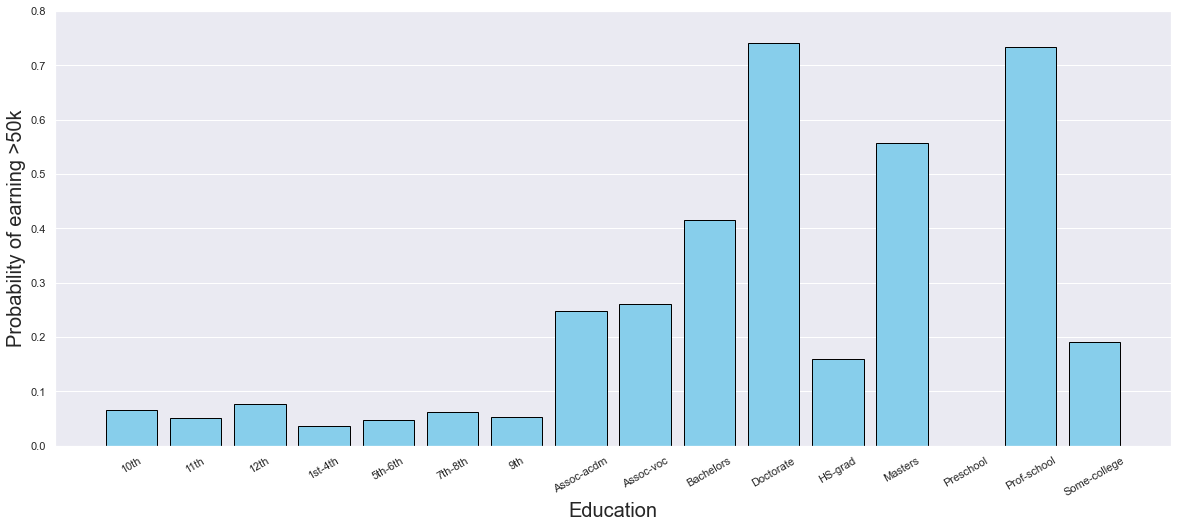

In [16]:
# probability of belonging to the group with the highest income
education_income = df.groupby('Education')['Income'].mean() # there is correlation as spected

plt.figure(figsize=(20, 8))
plt.ylim(0,0.8)
plt.xticks(rotation=30) # rotate axis text
plt.bar(education_income.index.astype(str), education_income,
       color = 'SkyBlue', edgecolor='black' )
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Education', size=20)
plt.grid(axis='y')

Probability of earning >50K annually increases with higher education

#### Marital Status

In [17]:
df['marital-status'].unique() 

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

There are no null values.

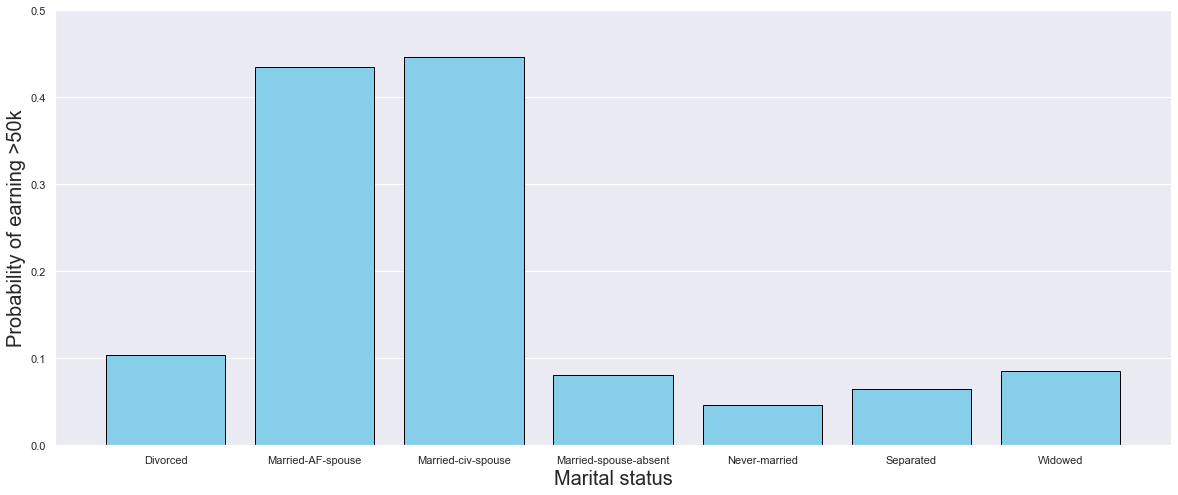

In [19]:
# probability of belonging to the group with the highest income
marital_income = df.groupby('marital-status')['Income'].mean()

plt.figure(figsize=(20, 8))
plt.ylim(0,0.5)
plt.bar(marital_income.index.astype(str), marital_income,
       color = 'SkyBlue', edgecolor='black' )
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Marital status', size=20)
plt.grid(axis='y')

As expected married people have a higher probability of having a higher income.

#### Occupation

In [20]:
df['Occupation'].value_counts() 

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: Occupation, dtype: int64

There are 1843 missing values.

In [21]:
# Show null values in common
work_ocupation = df.loc[df['Workclass'] == df['Occupation'],'Workclass']
work_ocupation.value_counts()

?    1836
Name: Workclass, dtype: int64

There are 1836 null values in common between Workclass and Occupation.

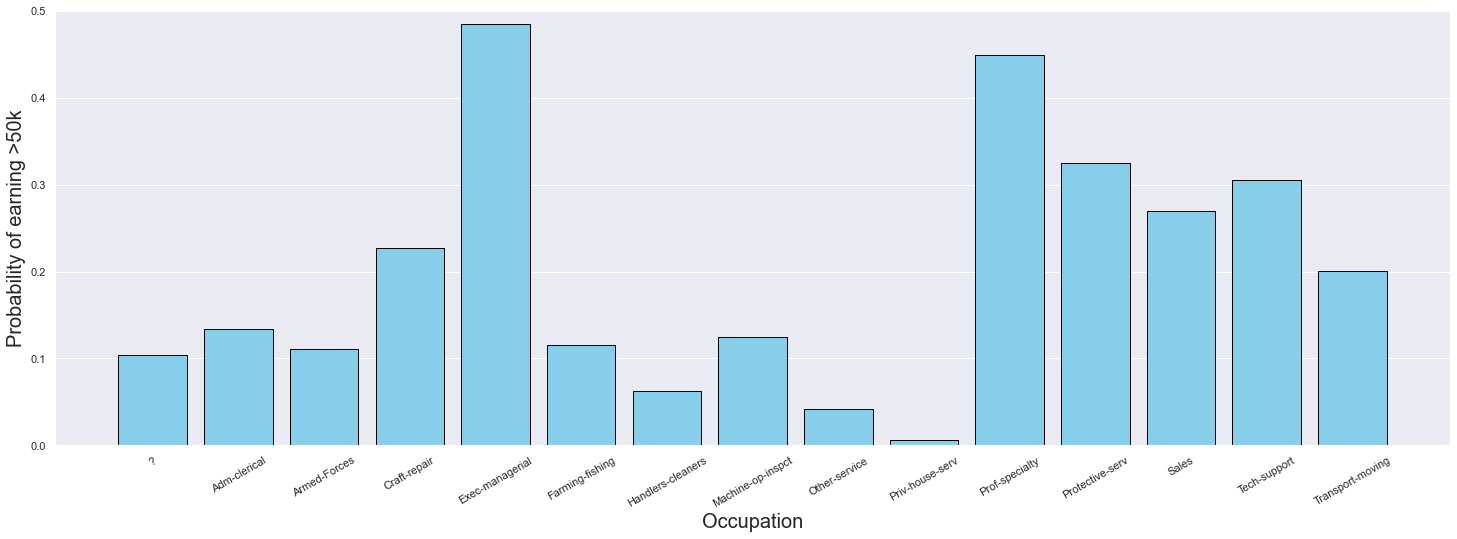

In [23]:
# probability of belonging to the group with the highest income
occupation_income = df.groupby('Occupation')['Income'].mean()

plt.figure(figsize=(25, 8))
plt.ylim(0,0.5)
plt.xticks(rotation=30) # rotate axis text
plt.bar(occupation_income.index.astype(str), occupation_income,
       color = 'skyblue', edgecolor='black' )
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Occupation', size=20)
plt.grid(axis='y')

#### Relationship

In [24]:
df['Relationship'].value_counts() 

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: Relationship, dtype: int64

There are no null values.

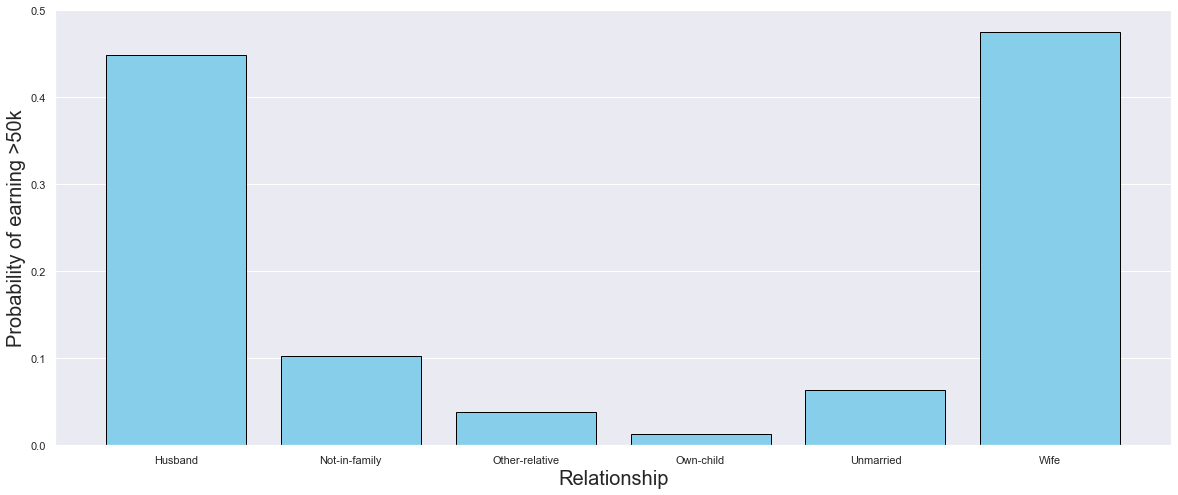

In [25]:
# probability of belonging to the group with the highest income
relationship_income = df.groupby('Relationship')['Income'].mean()

plt.figure(figsize=(20, 8))
plt.ylim(0,0.5)
plt.bar(relationship_income.index.astype(str), relationship_income,
       color = 'SkyBlue', edgecolor='black')
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Relationship', size=20)
plt.grid(axis='y')

Evidently being married increases the probability of earning more than 50k.

In [26]:
df['Race'].value_counts()

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: Race, dtype: int64

There are no null values.

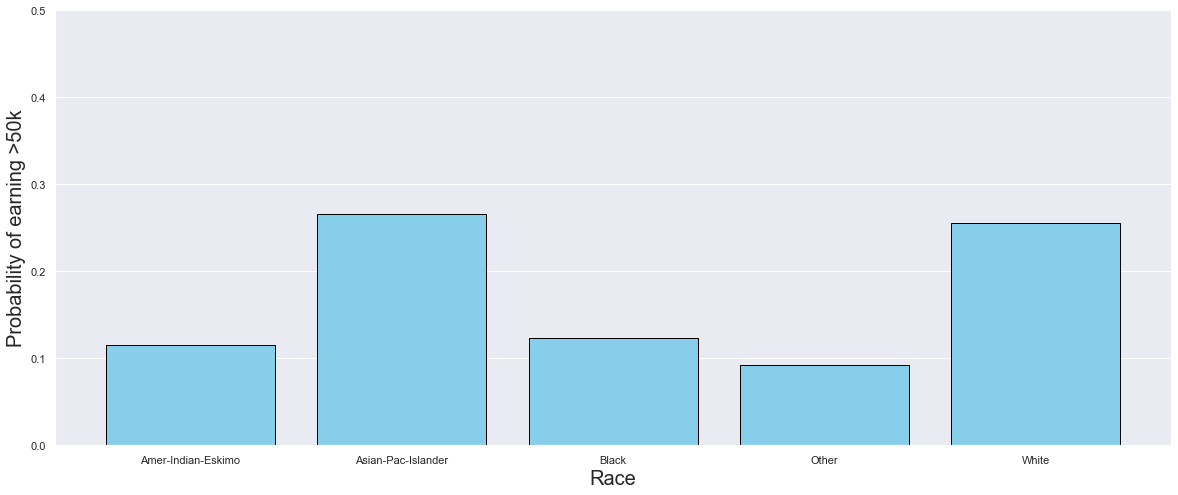

In [28]:
# probability of belonging to the group with the highest income
race_income = df.groupby('Race')['Income'].mean()

plt.figure(figsize=(20, 8))
plt.ylim(0,0.5)
plt.bar(race_income.index.astype(str), race_income,
       color = 'SkyBlue', edgecolor='black')
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Race', size=20)
plt.grid(axis='y')


White people and Asian-Pac-Islander have the higher probabilities of having an income >50k.

#### Sex

In [29]:
df['Sex'].value_counts()

Male      21790
Female    10771
Name: Sex, dtype: int64

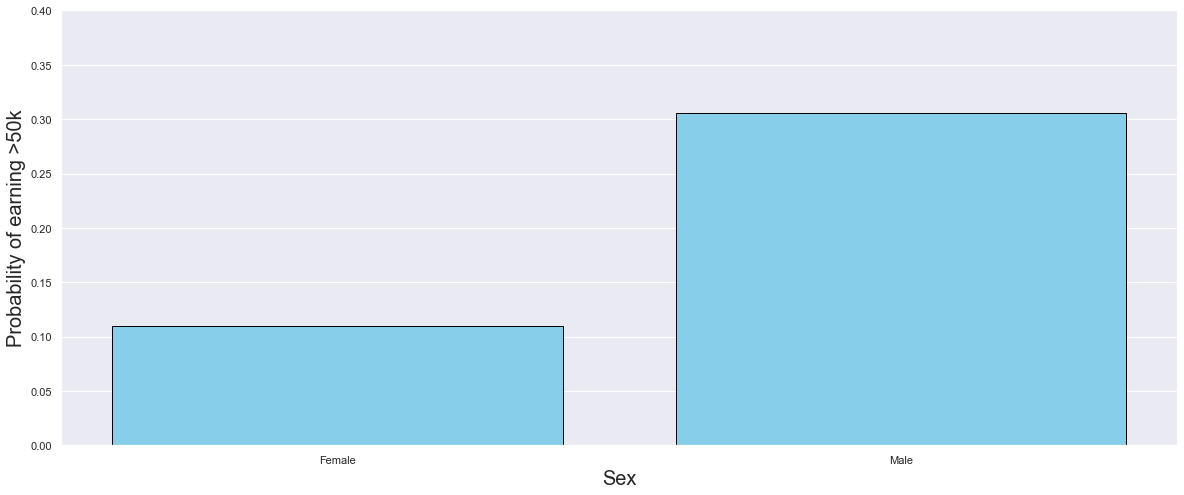

In [34]:
sex_income = df.groupby('Sex')['Income'].mean()

plt.figure(figsize=(20, 8))
plt.ylim(0,0.4)
plt.bar(sex_income.index.astype(str), sex_income,
       color = 'SkyBlue', edgecolor='black')
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Sex', size=20)
plt.grid(axis='y')


Males have a higher probability of having an income >50k than females.

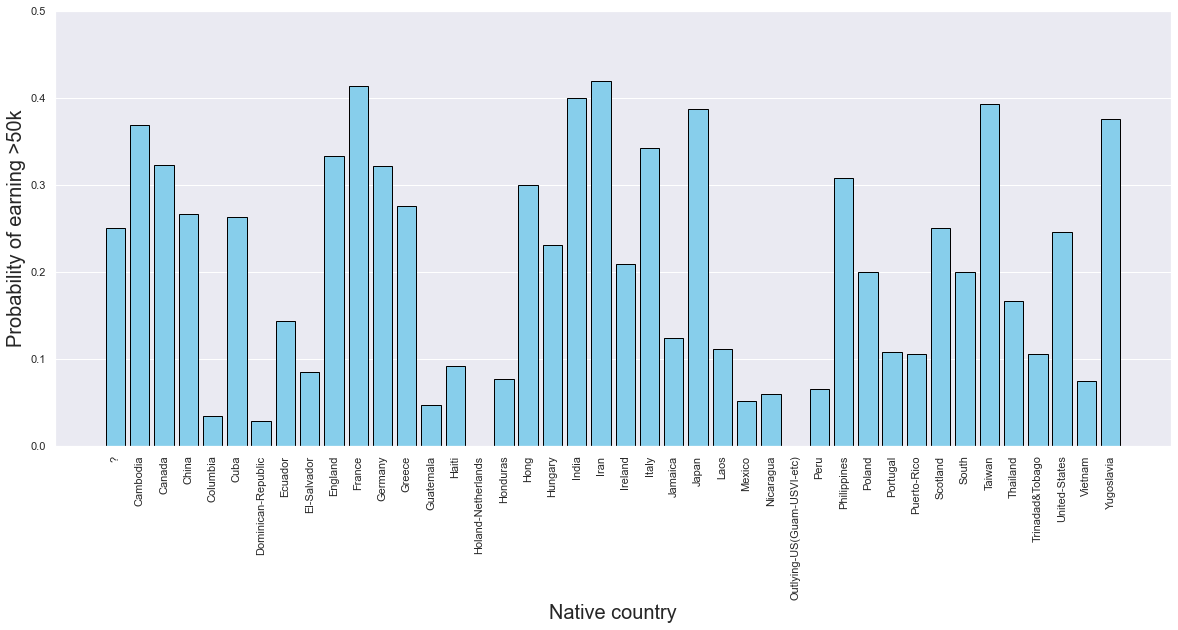

In [37]:
nat_income = df.groupby('Native country')['Income'].mean()

plt.figure(figsize=(20, 8))
plt.ylim(0,0.5)
plt.bar(nat_income.index.astype(str), nat_income,
       color = 'SkyBlue', edgecolor='black')
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Native country', size=20)
plt.xticks(rotation=90)
plt.grid(axis='y')

#### Native Country

In [38]:
df['Native country'].unique() 

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

There is missing data in the form of '?'.

In [39]:
# Show number of missing values
df.loc[df['Native country'] == '?', 'Native country'].count() 

583

In [40]:
#Show if missing values have something to do with occupation missing data
df.loc[df['Native country'] == 'Occupation','Occupation' ].count()

0

In [41]:
# Show if missing values have something to do with workclass missing data
df.loc[df['Native country'] == 'Workclass','Workclass' ].count()

0

In [42]:
df['Native country'].value_counts()

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

The missing value in Native country has nothing in common with Occupation or Workclass missing values.

### 2.3 Continuous variables 

#### 2.3.1 Correlation matrix

In [43]:
df.info() # Show continuous variables 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Index           32561 non-null  int64 
 1   Age             32561 non-null  int64 
 2   Workclass       32561 non-null  object
 3   fnlwgt          32561 non-null  int64 
 4   Education       32561 non-null  object
 5   Edu years       32561 non-null  int64 
 6   marital-status  32561 non-null  object
 7   Occupation      32561 non-null  object
 8   Relationship    32561 non-null  object
 9   Race            32561 non-null  object
 10  Sex             32561 non-null  object
 11  Capital-gain    32561 non-null  int64 
 12  Capital-loss    32561 non-null  int64 
 13  Hours per week  32561 non-null  int64 
 14  Native country  32561 non-null  object
 15  Income          32561 non-null  int64 
dtypes: int64(8), object(8)
memory usage: 4.0+ MB


<AxesSubplot:>

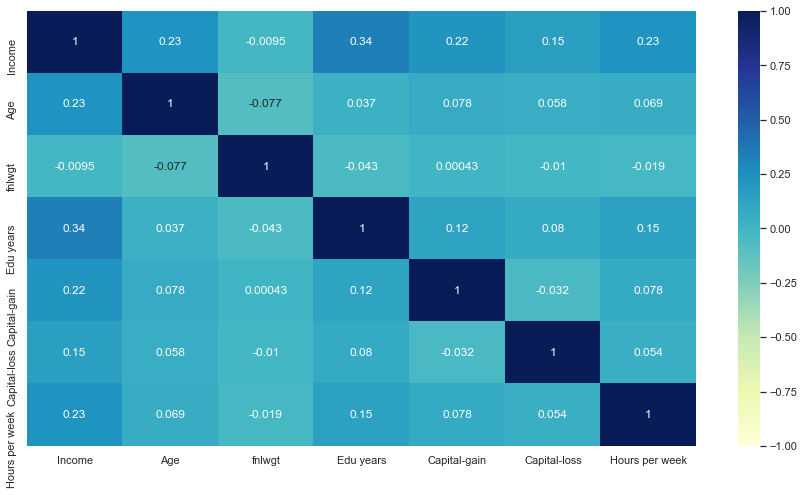

In [45]:
# Group all continous variables 
df_continous = df[['Income', 'Age', 'fnlwgt', 'Edu years', 'Capital-gain', 'Capital-loss', 'Hours per week']]
# Correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(data=df_continous.corr(), annot=True, vmin=-1, vmax=1, cmap="YlGnBu")

fnlwgt does not have a high correlation with income. It can be dropped.

#### Age

In [46]:
df['Age'].unique()

array([39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 30, 23, 32, 40, 34, 25, 43,
       54, 35, 59, 56, 19, 20, 45, 22, 48, 21, 24, 57, 44, 41, 29, 18, 47,
       46, 36, 79, 27, 67, 33, 76, 17, 55, 61, 70, 64, 71, 68, 66, 51, 58,
       26, 60, 90, 75, 65, 77, 62, 63, 80, 72, 74, 69, 73, 81, 78, 88, 82,
       83, 84, 85, 86, 87], dtype=int64)

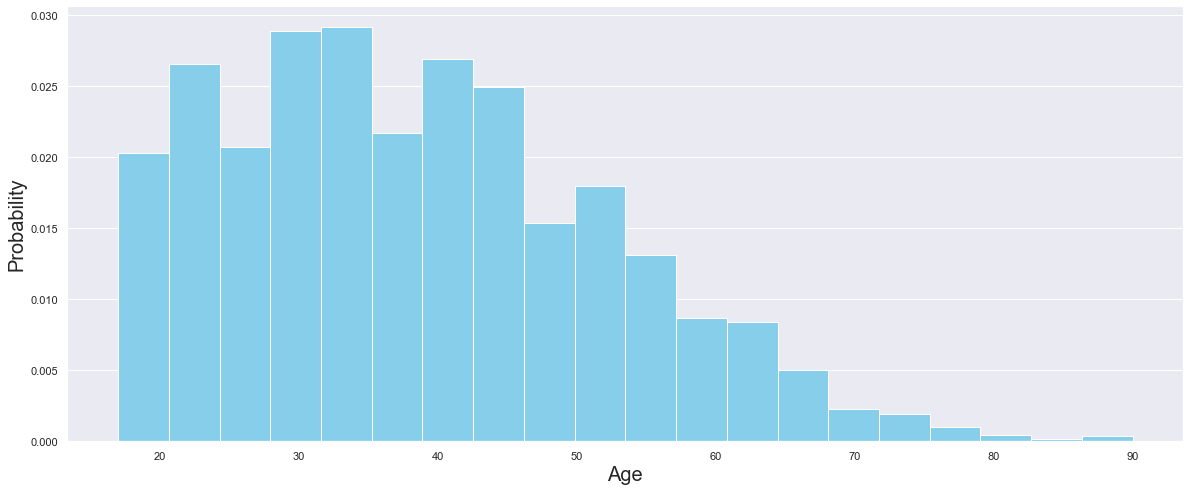

In [47]:
# plot histogram
plt.figure(figsize=(20, 8))
plt.hist(df['Age'],density=True, bins=20, color = 'SkyBlue')
plt.ylabel('Probability', size=20)
plt.xlabel('Age', size=20)
plt.grid(axis='y')

In [48]:
# Show average age by income
df.groupby("Income")["Age"].mean() 

Income
0    36.783738
1    44.249841
Name: Age, dtype: float64

People with higher income are older on average.

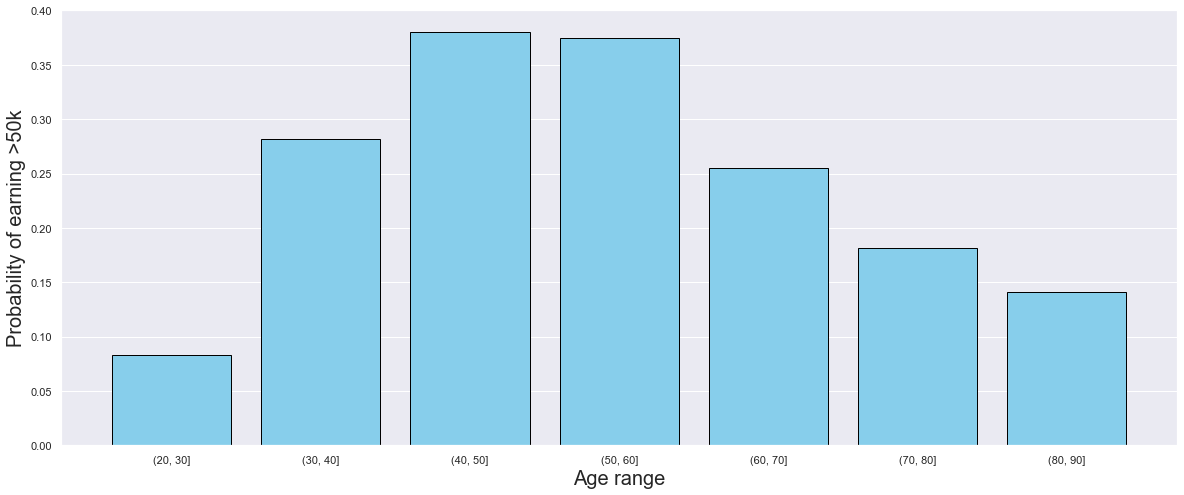

In [50]:
# divide age into groups
age_range = pd.cut(df['Age'], bins = [20,30,40,50,60,70,80,90])

# show probability of belonging to the group with the highest income
age_income = df.groupby(age_range)['Income'].mean()

# barplot showing probability of belonging to the group with the highest income per age range
plt.figure(figsize=(20, 8))
plt.ylim(0,0.4)
plt.bar(age_income.index.astype(str), age_income, color = 'SkyBlue',
       edgecolor='black')
plt.ylabel('Probability of earning >50k', size=20)
plt.xlabel('Age range', size=20)
plt.grid(axis='y')

#### fnlwgt

In [51]:
df.loc[df['fnlwgt'] == '?'] 

,Index,Age,Workclass,fnlwgt,Education,Edu years,marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours per week,Native country,Income


There are no null values in fnlwgt.

#### Edu years

In [52]:
df['Edu years'].value_counts()

9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: Edu years, dtype: int64

In [53]:
df['Education'].value_counts() # we can see that it has the same number of values

HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: Education, dtype: int64

#### Capital Gain

In [54]:
df['Capital-gain'].unique()

array([ 2174,     0, 14084,  5178,  5013,  2407, 14344, 15024,  7688,
       34095,  4064,  4386,  7298,  1409,  3674,  1055,  3464,  2050,
        2176,   594, 20051,  6849,  4101,  1111,  8614,  3411,  2597,
       25236,  4650,  9386,  2463,  3103, 10605,  2964,  3325,  2580,
        3471,  4865, 99999,  6514,  1471,  2329,  2105,  2885, 25124,
       10520,  2202,  2961, 27828,  6767,  2228,  1506, 13550,  2635,
        5556,  4787,  3781,  3137,  3818,  3942,   914,   401,  2829,
        2977,  4934,  2062,  2354,  5455, 15020,  1424,  3273, 22040,
        4416,  3908, 10566,   991,  4931,  1086,  7430,  6497,   114,
        7896,  2346,  3418,  3432,  2907,  1151,  2414,  2290, 15831,
       41310,  4508,  2538,  3456,  6418,  1848,  3887,  5721,  9562,
        1455,  2036,  1831, 11678,  2936,  2993,  7443,  6360,  1797,
        1173,  4687,  6723,  2009,  6097,  2653,  1639, 18481,  7978,
        2387,  5060], dtype=int64)

#### Capital Loss

In [55]:
df['Capital-loss'].unique()

array([   0, 2042, 1408, 1902, 1573, 1887, 1719, 1762, 1564, 2179, 1816,
       1980, 1977, 1876, 1340, 2206, 1741, 1485, 2339, 2415, 1380, 1721,
       2051, 2377, 1669, 2352, 1672,  653, 2392, 1504, 2001, 1590, 1651,
       1628, 1848, 1740, 2002, 1579, 2258, 1602,  419, 2547, 2174, 2205,
       1726, 2444, 1138, 2238,  625,  213, 1539,  880, 1668, 1092, 1594,
       3004, 2231, 1844,  810, 2824, 2559, 2057, 1974,  974, 2149, 1825,
       1735, 1258, 2129, 2603, 2282,  323, 4356, 2246, 1617, 1648, 2489,
       3770, 1755, 3683, 2267, 2080, 2457,  155, 3900, 2201, 1944, 2467,
       2163, 2754, 2472, 1411], dtype=int64)

#### Working Hours per week

In [56]:
df['Hours per week'].unique()

array([40, 13, 16, 45, 50, 80, 30, 35, 60, 20, 52, 44, 15, 25, 38, 43, 55,
       48, 58, 32, 70,  2, 22, 56, 41, 28, 36, 24, 46, 42, 12, 65,  1, 10,
       34, 75, 98, 33, 54,  8,  6, 64, 19, 18, 72,  5,  9, 47, 37, 21, 26,
       14,  4, 59,  7, 99, 53, 39, 62, 57, 78, 90, 66, 11, 49, 84,  3, 17,
       68, 27, 85, 31, 51, 77, 63, 23, 87, 88, 73, 89, 97, 94, 29, 96, 67,
       82, 86, 91, 81, 76, 92, 61, 74, 95], dtype=int64)

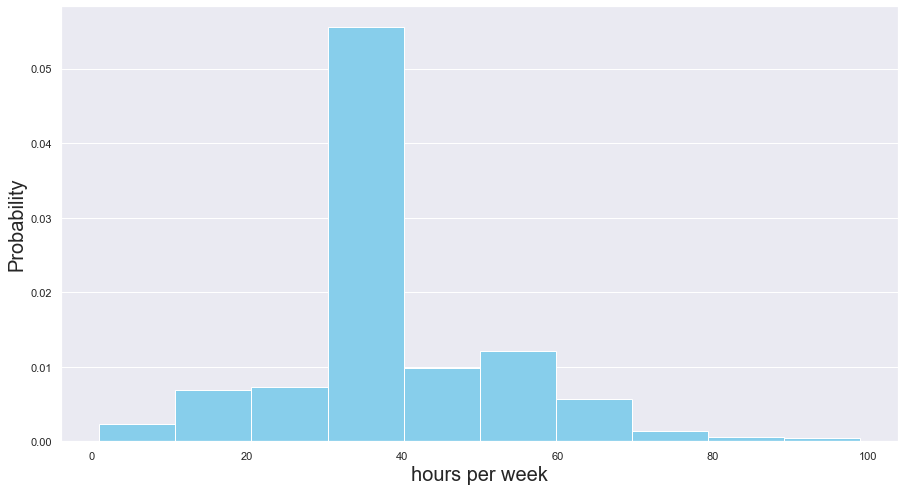

In [57]:
# plot histogram
plt.figure(figsize=(15, 8))
plt.hist(df['Hours per week'],density=True, bins=10,  color = 'SkyBlue')
plt.ylabel('Probability', size=20)
plt.xlabel('hours per week', size=20)
plt.grid(axis='y')

### 3. Cleaning the data

#### 3.1 Drop useless variables
We have seen that the 'Edu years' variable does not provide any additional information in correlation with the income so we will drop these variables.
We will also drop the Index variables as it is redundant.

In [58]:

df = df.drop('Edu years', axis=1)
df = df.drop('Index', axis=1)
df.shape

(32561, 14)

#### 3.2 Missing data

As there is a lot of data and the missing values are just a small part of the data, we can drop those entries.

In [59]:
df = df.loc[ (df['Workclass'] != '?') & (df['Occupation'] != '?') & (df['Native country']!= '?')]
df.shape

(30162, 14)

#### 3.3 Outliers

In [60]:
# It is a class which will help in checking outliers in different columns of the data
# Here, It uses three techniques to find the outliers (we can use anyone of them)
# The techniques are:-
# * IQR
# * Z score
# * Standard Deviation

class Outliers(object):
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.min = df[col].min()
        self.max = df[col].max()
        self.mean = df[col].mean()
        self.std = df[col].std()
        self.median = df[col].median()
        self.quantile_25 = df[col].quantile(0.25)
        self.quantile_75 = df[col].quantile(0.75)
    
    @property
    def info(self):
        
        print('{}:- '.format(self.col))
        print('Minimum:- {}'.format(self.min))
        print('Maximum:- {}'.format(self.max))
        print('Mean:- {}'.format(self.mean))
        print('Median:- {}'.format(self.median))
        print('Standard Deviation:- {}'.format(self.std))
        print('First Quantile:- {}'.format(self.quantile_25))
        print('Third Quantile:- {}'.format(self.quantile_75))
        
        
class IQR(Outliers):
    def __init__(self, df, col):
        super().__init__(df, col) 
        
        self.IQR = self.quantile_75 - self.quantile_25
        self.lower_bound = self.quantile_25 - (1.5 * self.IQR)
        self.upper_bound = self.quantile_75 + (1.5 * self.IQR)
        
    def iqr_outliers(self):
        
        return self.df.loc[(self.df[self.col] < self.lower_bound) | (self.df[self.col] > self.upper_bound), self.col].values
    
    def removed_outliers(self):
        return self.df.loc[(self.df[self.col] > self.lower_bound) & (self.df[self.col] < self.upper_bound)]
    

class Z_score(Outliers):
    def __init__(self, df, col):
        super().__init__(df, col)
        
        pass
    
    def z_score_outliers(self):
        outlier = []
        for i in self.df[self.col]:
            z = (i - self.mean) / self.std
            if abs(z) > 3:
                outlier.append(i)
                
        return outlier
    
    def removed_outliers(self):
        
        df_copy = self.df
        for i in self.z_score_outliers():
            df_copy = df_copy.loc[df_copy[self.col] != i]
            
        return df_copy
    
class StandardDeviation(Outliers):
    def __init__(self, df, col):
        super().__init__(df, col)
        pass
    
    @property
    def std_calc(self):
        lower_std = self.mean - (3 * self.std)
        upper_std = self.mean + (3 * self.std)
        
        return lower_std, upper_std
    
    def std_outliers(self):
        lower_std, upper_std = self.std_calc
        return self.df.loc[(self.df[self.col] < lower_std) | (self.df[self.col] > upper_std), self.col].values
    
    def removed_outliers(self):
        lower_std, upper_std = self.std_calc
        return self.df.loc[(self.df[self.col] > lower_std) & (self.df[self.col] < upper_std)]

In [61]:
# It will show the outliers of the columns

for i in df.columns:
    if df[i].dtype != object:
        
        out = Outliers(df, i)
        iqr = IQR(df, i)
        z_score = Z_score(df, i)
        std = StandardDeviation(df, i)
        
        print('Column:- {}\n'.format(i))
        print('INFO:- \n')
        out.info
        
        print('\nOutlier with IQR:- {}\n'.format(i))
        print(iqr.iqr_outliers())
        print('----------> dataset shape after removing outliers with iqr:- {}\n'.format(iqr.removed_outliers().shape))
        
        print('\nOutlier with Z_score:- {}\n'.format(i))
        print(z_score.z_score_outliers())
        print('----------> dataset shape after removing outliers with z_score:- {}\n'.format(z_score.removed_outliers().shape))
        
        print('\nOutlier with Standard deviation:- {}\n'.format(i))
        print(std.std_outliers())
        print('----------> dataset shape after removing outliers with Standard Deviation:{}\n'.format(std.removed_outliers().shape))
        print('*'*100)

Column:- Age

INFO:- 

Age:- 
Minimum:- 17
Maximum:- 90
Mean:- 38.437901995888865
Median:- 37.0
Standard Deviation:- 13.134664776856338
First Quantile:- 28.0
Third Quantile:- 47.0

Outlier with IQR:- Age

[79 76 90 77 76 81 78 90 88 90 77 90 77 78 80 90 81 81 76 80 90 76 79 76
 81 76 90 90 80 90 90 79 78 79 84 90 77 80 77 90 81 83 84 79 76 85 82 79
 77 90 76 90 84 78 78 76 80 90 90 77 76 84 76 90 76 90 76 77 90 77 78 77
 81 78 82 81 77 76 80 90 80 84 82 78 79 76 90 84 90 83 78 80 77 78 76 79
 80 79 80 90 90 90 81 76 83 90 90 81 80 80 90 79 77 77 80 76 82 85 80 79
 90 76 76 77 76 79 81 77 88 90 82 76 88 76 77 83 76 77 79 77 86 90 77 82
 83 81 76 79 76 84 78 76 76 76 78 84 79 78 90 80 81 78 81 90 80 82 90 90
 85]
----------> dataset shape after removing outliers with iqr:- (29993, 14)


Outlier with Z_score:- Age

[79, 90, 81, 78, 90, 88, 90, 90, 78, 80, 90, 81, 81, 80, 90, 79, 81, 90, 90, 80, 90, 90, 79, 78, 79, 84, 90, 80, 90, 81, 83, 84, 79, 85, 82, 79, 90, 90, 84, 78, 78, 80, 90, 90,

After looking at the outliers, we can now remove the outliers of: <br>
* Age : z_score or Std Deviation <br>
* fnlwgt : z_score or Std Devation <br>
* Hours per week : z_score or Std Devation <br>
* Capital Gain : Average of different groups <br>
* Capital Loss : Average of different groups

In [62]:
# Removing outliers of age, fnlwgt, hours-per-week
df = Z_score(df, 'Age').removed_outliers()
df = StandardDeviation(df, 'fnlwgt').removed_outliers()
df = Z_score(df, 'Hours per week').removed_outliers()

In [63]:
df = df.reset_index().rename({'index': 'new_index'}, axis = 1).drop('new_index', axis = 1)

In [64]:
# Working on outliers of capital-gain 1
# making the group in which we will substitute the mean values of that group
cap_gn = {}
for i in np.arange(1, 110000, 10000):
    
        cap_gn[str(i) + ' - ' + str(i + 10000)] = df.loc[(df['Capital-gain'] >= i) & (df['Capital-gain'] < i + 10000), 'Capital-gain'].mean()
        
for i,j in cap_gn.items():
    if j is np.nan:
        cap_gn[i] = 0
        
cap_gn

{'1 - 10001': 4935.472540045766,
 '10001 - 20001': 14307.728778467908,
 '20001 - 30001': 24301.095890410958,
 '30001 - 40001': 34095.0,
 '40001 - 50001': 41310.0,
 '50001 - 60001': 0,
 '60001 - 70001': 0,
 '70001 - 80001': 0,
 '80001 - 90001': 0,
 '90001 - 100001': 99999.0,
 '100001 - 110001': 0}

In [65]:
# Working on outliers of capital-gain 2
# Substituing mean values in capital-gain
for i in range(len(df['Capital-gain'])):
    for j,k in cap_gn.items(): 
        t = int(j.split(' ')[0])
        r = int(j.split(' ')[-1])
        if (df.loc[i, 'Capital-gain'] >= t) & (df.loc[i, 'Capital-gain'] < r):
            df.loc[i, 'Capital-gain'] = k

In [66]:
df['Capital-gain'].value_counts()

0.000000        26845
4935.472540      1748
14307.728778      483
99999.000000      142
24301.095890       73
34095.000000        2
41310.000000        2
Name: Capital-gain, dtype: int64

Similarly for Capital Loss

In [67]:
cap_ls = {}
for i in np.arange(1, 6000, 1000):
    
        cap_ls[str(i) + ' - ' + str(i + 1000)] = df.loc[(df['Capital-loss'] >= i) & (df['Capital-loss'] < i + 1000), 'Capital-loss'].mean()
        
for i,j in cap_ls.items():
    if j is np.nan:
        cap_ls[i] = 0
        
cap_ls

{'1 - 1001': 608.8823529411765,
 '1001 - 2001': 1786.8620689655172,
 '2001 - 3001': 2271.772893772894,
 '3001 - 4001': 3672.8571428571427,
 '4001 - 5001': 0,
 '5001 - 6001': 0}

In [68]:
for i in range(len(df['Capital-loss'])):
    for j,k in cap_ls.items(): 
        t = int(j.split(' ')[0])
        r = int(j.split(' ')[-1])
        if (df.loc[i, 'Capital-loss'] >= t) & (df.loc[i, 'Capital-loss'] < r):
            df.loc[i, 'Capital-loss'] = k

In [69]:
df['Capital-loss'].value_counts()

0.000000       27908
1786.862069     1073
2271.772894      273
608.882353        34
3672.857143        7
Name: Capital-loss, dtype: int64

In [70]:
# Transforming columns into numerical from categorical values
# as it supports numerical and not categorical values
# And also scaling the existing numerical values 

Ordenc = OrdinalEncoder()
labenc = LabelEncoder()
scale = StandardScaler()

num_enc = ['Age', 'fnlwgt', 'Capital-gain', 'Capital-loss', 'Hours per week']
cat_enc = ['Workclass', 'Education', 'marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native country']
cat_enc_tar = ['Income']

df[cat_enc] = Ordenc.fit_transform(df[cat_enc])
df[cat_enc_tar] = labenc.fit_transform(df[cat_enc_tar])
df[num_enc] = scale.fit_transform(df[num_enc])

In [71]:
col = ['Workclass', 'Education', 'marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native country', 'Income']
total_col = ['Workclass', 'Education', 'marital-status', 'Occupation',
             'Relationship', 'Race', 'Sex', 'Native country', 'Income', 'Age', 'fnlwgt', 'Capital-gain', 'Capital-loss', 
             'Hours per week']

trans_col = make_column_transformer((OrdinalEncoder(), col),
                                    remainder = 'passthrough')

corr_df = trans_col.fit_transform(df)
corr_df = pd.DataFrame(corr_df, columns = total_col)
corr_df

,Workclass,Education,marital-status,Occupation,Relationship,Race,Sex,Native country,Income,Age,fnlwgt,Capital-gain,Capital-loss,Hours per week
0,5.0,9.0,4.0,0.0,1.0,4.0,1.0,38.0,0.0,0.058620,-1.140520,0.525530,-0.219879,-0.055507
1,4.0,9.0,2.0,3.0,0.0,4.0,1.0,38.0,0.0,0.916053,-1.079231,-0.147354,-0.219879,-2.569472
2,2.0,11.0,0.0,5.0,1.0,4.0,1.0,38.0,0.0,-0.019328,0.320372,-0.147354,-0.219879,-0.055507
3,2.0,1.0,2.0,5.0,0.0,2.0,1.0,38.0,0.0,1.149899,0.522113,-0.147354,-0.219879,-0.055507
4,2.0,9.0,2.0,9.0,5.0,2.0,0.0,4.0,0.0,-0.798813,1.618739,-0.147354,-0.219879,-0.055507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29290,2.0,7.0,2.0,12.0,5.0,4.0,0.0,38.0,0.0,-0.876761,0.760935,-0.147354,-0.219879,-0.241726
29291,2.0,11.0,2.0,6.0,0.0,4.0,1.0,38.0,1.0,0.136569,-0.327653,-0.147354,-0.219879,-0.055507
29292,2.0,11.0,6.0,0.0,4.0,4.0,0.0,38.0,0.0,1.539641,-0.353713,-0.147354,-0.219879,-0.055507
29293,2.0,11.0,4.0,0.0,3.0,4.0,1.0,38.0,0.0,-1.266503,0.170655,-0.147354,-0.219879,-1.917703


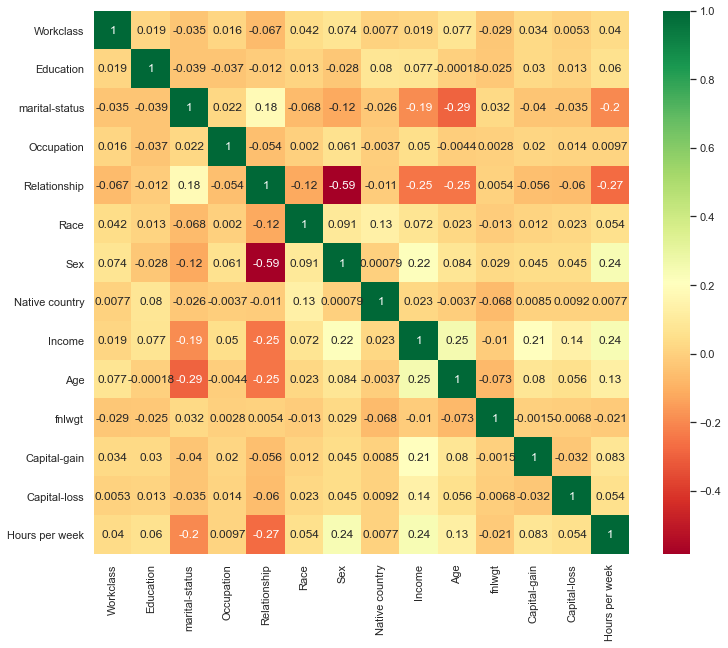

In [72]:
plt.figure(figsize = (12, 10))

sns.heatmap(corr_df.corr(), annot = True, cmap="RdYlGn")
plt.show()

Popular Occupations

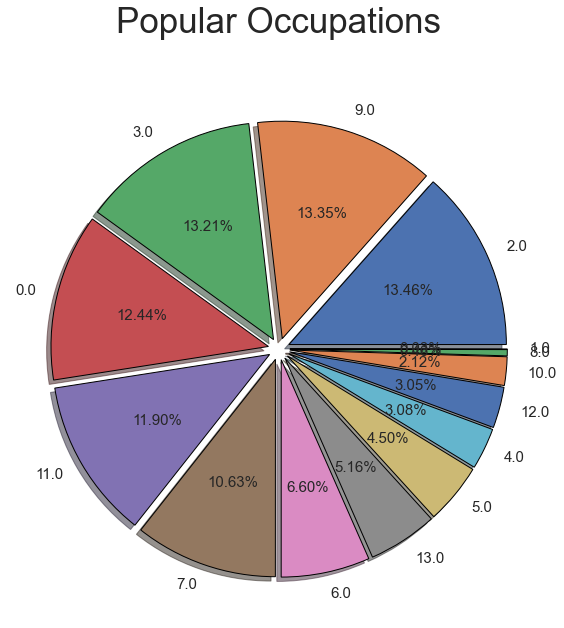

In [73]:
occ_gr = df['Occupation'].value_counts()

plt.figure(figsize = (10, 10))

plt.pie(occ_gr.values, labels = occ_gr.index, 
        wedgeprops = {'edgecolor': 'black'}, 
        textprops = {'fontsize': 15},
        autopct = '%1.2f%%', 
        shadow = True, 
        explode = np.full(len(occ_gr), 0.05))

plt.title('Popular Occupations\n', fontsize = 35)
plt.show()

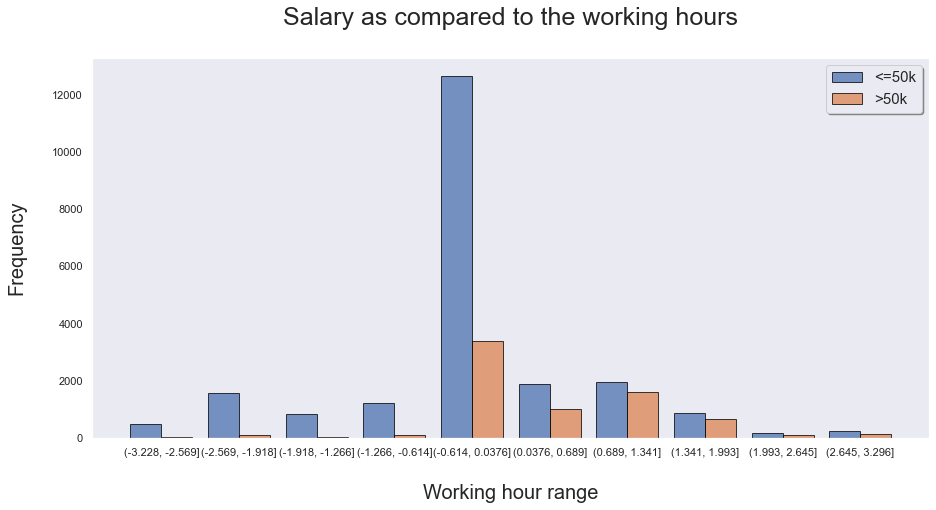

In [74]:
wk_hr_dis = pd.cut(df['Hours per week'], 10)

temp_wk = df.copy()
temp_wk['work_hr_dis'] = wk_hr_dis

viz_wk_hr_sal = temp_wk.groupby(['work_hr_dis', 'Income'])[['Income']].count().unstack()['Income']

plt.figure(figsize = (15, 7))

hr_d = np.arange(len(wk_hr_dis.unique()))
width = 0.4

plt.bar(hr_d - width / 2, viz_wk_hr_sal[0], width = width, alpha = 0.75, edgecolor = 'black', label = '<=50k')
plt.bar(hr_d + width / 2, viz_wk_hr_sal[1], width = width, alpha = 0.75, edgecolor = 'black', label = '>50k')

plt.title('Salary as compared to the working hours\n', fontsize = 25)
plt.xlabel('\nWorking hour range', fontsize = 20)
plt.ylabel('Frequency\n', fontsize = 20)

plt.xticks(hr_d, wk_hr_dis.unique().sort_values())
plt.legend(frameon = True, shadow = True, fontsize = 15, loc = 'best')
plt.show()

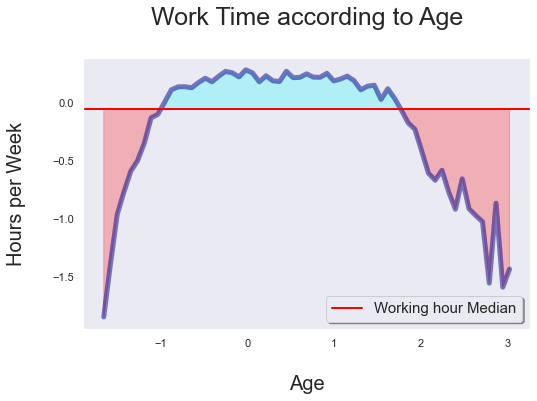

In [75]:
age_wk_hr = df.groupby('Age')[['Hours per week']].aggregate(np.mean)
wk_hr_median = df['Hours per week'].median()

plt.figure(figsize = (8, 5))

plt.plot(age_wk_hr.index, age_wk_hr.iloc[:, 0], linewidth = 5, color = 'darkblue', alpha = 0.5)

plt.fill_between(age_wk_hr.index, age_wk_hr.iloc[:, 0], wk_hr_median, 
                 where = (age_wk_hr.iloc[:, 0] > wk_hr_median),
                 interpolate= True, alpha = 0.25, color = 'cyan')

plt.fill_between(age_wk_hr.index, age_wk_hr.iloc[:, 0], wk_hr_median, 
                 where = (age_wk_hr.iloc[:, 0] < wk_hr_median),
                 interpolate= True, alpha = 0.25, color = 'red')


plt.axhline(wk_hr_median, color = 'red', linewidth = 2, 
            label = 'Working hour Median')

plt.title('Work Time according to Age\n', fontsize = 25)
plt.xlabel('\nAge', fontsize = 20)
plt.ylabel('Hours per Week\n', fontsize = 20)

plt.legend(loc = 'best', frameon = True, shadow = True, fontsize = 15)
plt.show()

### 4. Split data

Split the data into dependent and independent variables, and then split the dependent variables into continuous variables and categorical variables.

In [76]:
# Split into dependent and independent variables
X = df.drop('Income', axis=1)
y = df['Income']

In [77]:
# Split X into continous variables and categorical variables

X_continous  = X[['Age', 'Capital-gain', 'Capital-loss', 'Hours per week']]

X_categorical = X[['Workclass', 'Education', 'marital-status', 'Occupation', 'Relationship', 'Race',
                   'Sex', 'Native country']]

To concatenate the categorical and continuous datasets we need to get dummies.

In [78]:
# Get the dummies
X_encoded = pd.get_dummies(X_categorical)
# Concatenate both continous and encoded sets:
X = pd.concat([X_continous, X_encoded],axis=1)
X

,Age,Capital-gain,Capital-loss,Hours per week,Workclass,Education,marital-status,Occupation,Relationship,Race,Sex,Native country
0,0.058620,0.525530,-0.219879,-0.055507,5.0,9.0,4.0,0.0,1.0,4.0,1.0,38.0
1,0.916053,-0.147354,-0.219879,-2.569472,4.0,9.0,2.0,3.0,0.0,4.0,1.0,38.0
2,-0.019328,-0.147354,-0.219879,-0.055507,2.0,11.0,0.0,5.0,1.0,4.0,1.0,38.0
3,1.149899,-0.147354,-0.219879,-0.055507,2.0,1.0,2.0,5.0,0.0,2.0,1.0,38.0
4,-0.798813,-0.147354,-0.219879,-0.055507,2.0,9.0,2.0,9.0,5.0,2.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29290,-0.876761,-0.147354,-0.219879,-0.241726,2.0,7.0,2.0,12.0,5.0,4.0,0.0,38.0
29291,0.136569,-0.147354,-0.219879,-0.055507,2.0,11.0,2.0,6.0,0.0,4.0,1.0,38.0
29292,1.539641,-0.147354,-0.219879,-0.055507,2.0,11.0,6.0,0.0,4.0,4.0,0.0,38.0
29293,-1.266503,-0.147354,-0.219879,-1.917703,2.0,11.0,4.0,0.0,3.0,4.0,1.0,38.0


### 5. Models 

### 5.1 Logistic Regression

In [79]:
# Prepare the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1/3,
                                                    stratify=y,random_state=10 )

# MODEL
logit = LogisticRegression(max_iter=10000)
logit = logit.fit(X_train, y_train)

# CROSS VALIDATION
cv = StratifiedKFold(n_splits=3) # we make 3 splits
val_logit = cross_val_score(logit, X_train, y_train, cv=cv).mean()
val_logit # show validation set score

0.7918586789554531

In [80]:
# PREDICTIONS
logit_predictions = logit.predict(X_test)
acc_logit = accuracy_score(y_test,logit_predictions)
acc_logit # show test set score

0.789247311827957

In [81]:
class Tuning_types():
    grid = GridSearchCV
    random = RandomizedSearchCV
    
class Classifiers():

    # I've manually set some parameters of log because of some errors in my system
    # (you can try doing it without setting it manually)
    log = LogisticRegression(solver = 'liblinear', max_iter = 1000) 
    gnb = GaussianNB()
    


class Model(object):
    
    target_col = df.columns[-1]
    test_size = 0.25
    
    def __init__(self, df):
        
        self.df = df
        self.X = df.drop(Model.target_col, axis = 1).copy()
        self.y = df[Model.target_col].copy()
        
        
    def desc_cols(self):    
        oe = []
        ohe = []
        
        for i in self.df.columns[:-1]:
            if self.df[i].dtype == object:
                if self.df[i].nunique() <= 7:
                    oe.append(i)

                else:
                    ohe.append(i)
                    
        return oe, ohe
        
        
    @property
    def train_test_set(self):
  
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, stratify = self.y, 
                                                            test_size = Model.test_size, random_state = 0)
        
        return X_train, X_test, y_train, y_test
    
    def transform_columns(self, ss = None, oe = [], ohe = []):
        
        def ss_choice():
            if ss == None:
                return make_column_selector(dtype_include = ['int', 'float'])
            else:
                return ss
            
            
        temp = ''
        
        if ((oe == []) & (ohe == [])):
            oe, ohe = self.desc_cols()
            
        elif (ohe == []) & (oe != []):
            temp, ohe = self.desc_cols()
            
        elif (oe == []) & (ohe != []):
            oe, temp = self.desc_cols()
        
        trans_col = make_column_transformer((StandardScaler(), ss_choice()), 
                                           (OneHotEncoder(handle_unknown = 'ignore', sparse = False), ohe), 
                                           (OrdinalEncoder(), oe), 
                                           remainder  = 'passthrough')
        
        return trans_col
    
    @property
    def target_col_trans_col(self):
        
        return make_column_transformer((LabelEncoder(), Model.target_col), 
                                       remainder = 'passthrough')






class Logistic_Regression(Model):
    def __init__(self, df = df):
        super().__init__(df)
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_set
        self.clf_log = Classifiers().log
        self.tune = Tuning_types()
        
    def pipe_log(self, ss = None, oe = [], ohe = []):
        pipe = make_pipeline(self.transform_columns(ss = None, oe = oe, ohe = ohe), self.clf_log)
        
        return pipe
    
    def tune_params_log(self,
                    tuning = 'grid',
                    penalty = ['l1', 'l2'],
                    dual = [False],
                    tol = [0.0001, 0.001, 0.01, 0.1], 
                    C = [1, 2, 4, 5],
                    fit_intercept = [True],
                    intercept_scaling = [1],
                    class_weight = [None],
                    random_state = [None],
                    multi_class = ['auto'],
                    verbose = [0],
                    warm_start = [False],
                    n_jobs = [None],
                    l1_ratio = [None],
                                   ):
        
        params = {
            'logisticregression__penalty': penalty,
            'logisticregression__dual': dual,
            'logisticregression__tol': tol,
            'logisticregression__C': C,
            'logisticregression__fit_intercept': fit_intercept,
            'logisticregression__intercept_scaling': intercept_scaling,
            'logisticregression__class_weight': class_weight,
            'logisticregression__random_state': random_state,
            'logisticregression__multi_class': multi_class,
            'logisticregression__verbose': verbose,
            'logisticregression__warm_start': warm_start,
            'logisticregression__n_jobs': n_jobs,
            'logisticregression__l1_ratio': l1_ratio,
        }
        
        if tuning == 'grid':
            return self.tune.grid(self.pipe_log(), params, cv = 5, verbose = 10)
        
        elif tuning == 'random':
            return self.tune.random(self.pipe_log(), params, cv = 5, verbose = 10)
        
        else:
            return "ERROR: Invalid tuning type.\nSet tuning as in ['grid', 'random'] in the parameter."
        
        

        
        
class Gaussian_Naive_Bayes(Model):
    
    def __init__(self, df = df):
        super().__init__(df)

        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_set
        self.clf_gnb = Classifiers().gnb
        self.tune = Tuning_types()
    
    
    def pipe_gnb(self, ss = None, oe = [], ohe = []):
        pipe = make_pipeline(self.transform_columns(ss = None, oe = oe, ohe = ohe), self.clf_gnb)
        
        return pipe
    
    def tune_params_gnb(self, 
                    tuning = 'grid', 
                    var_smoothing = [1e-10, 1e-09, 1e-8],
                    priors = [None],
                    ):
        
        params = {
            'gaussiannb__var_smoothing': var_smoothing,
            'gaussiannb__priors': priors
        }
    
    
        if tuning == 'grid':
            return self.tune.grid(self.pipe_gnb(), params, cv = 5, verbose = 10)
        
        elif tuning == 'random':
            return self.tune.random(self.pipe_gnb(), params, cv = 5, verbose = 10)
        
        else:
            return "ERROR: Invalid tuning type.\nSet tuning as in ['grid', 'random'] in the parameter."
        
        
class Evaluate(Logistic_Regression,  
               Gaussian_Naive_Bayes):

    def __init__(self, df):
        super().__init__(df)
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_set


    def show(self, y_pred_nm_train, y_pred_nm_test, y_pred_tm_train, y_pred_tm_test):

        accuracy_tr_nm = accuracy_score(self.y_train, y_pred_nm_train)
        accuracy_ts_nm = accuracy_score(self.y_test, y_pred_nm_test)
        
        accuracy_tr_tm = accuracy_score(self.y_train, y_pred_tm_train)
        accuracy_ts_tm = accuracy_score(self.y_test, y_pred_tm_test)
        
        acc = pd.DataFrame({'Training Set': [accuracy_tr_nm, accuracy_tr_tm], 
                      'Testing Set': [accuracy_ts_nm, accuracy_ts_tm]},
                     index = ['Before parameter optimization', 
                              'After parameter optimization'])
        
        print('/' * 100, '\n')
        print('Acccuracy Score:- ')
        print('*' * 50)
        print(acc)
        print('*' * 50, '\n')
        
        
        # Confusion Matrix
        confusion_matrix_tr_nm = confusion_matrix(self.y_train, y_pred_nm_train)
        confusion_matrix_ts_nm = confusion_matrix(self.y_test, y_pred_nm_test)
        
        confusion_matrix_tr_tm = confusion_matrix(self.y_train, y_pred_tm_train)
        confusion_matrix_ts_tm = confusion_matrix(self.y_test, y_pred_tm_test)
        print('Confusion Matrix:- ')
        print('*' * 50)
        print('Confusion Matrix (Training Set):- ')
        print('Before parameter tuning:- \n', confusion_matrix_tr_nm)
        print('After parameter tuning:- \n', confusion_matrix_tr_tm)
        print('\n')
        print('Confusion Matrix (Testing Set):- ')
        print('Before parameter tuning:- \n', confusion_matrix_ts_nm)
        print('After parameter tuning:- \n', confusion_matrix_ts_tm)
        print('*' * 50, '\n')
        
        #heatmap conf matrix start
        sns.heatmap(confusion_matrix_ts_nm/np.sum(confusion_matrix_ts_nm), annot=True, 
            fmt='.2%', cmap='Blues')
        #heatmap conf matrix end
        
        # Classification Report
        classification_report_tr_nm = classification_report(self.y_train, y_pred_nm_train)
        classification_report_ts_nm = classification_report(self.y_test, y_pred_nm_test)
        
        classification_report_tr_tm = classification_report(self.y_train, y_pred_tm_train)
        classification_report_ts_tm = classification_report(self.y_test, y_pred_tm_test)
        
        print('Classification Report:- ')
        print('*' * 50)
        print('Classification Report (Training Set):- ')
        print('Before parameter tuning:- \n', classification_report_tr_nm)
        print('After parameter tuning:- \n', classification_report_tr_tm)
        
        print('\n')
        print('Classification Report (Testing Set):- ')
        print('Before parameter tuning:- \n', classification_report_ts_nm)
        print('After parameter tuning:- \n', classification_report_ts_tm)
        print('*' * 50, '\n')
        
        print('/' * 100)
        


    
    @property
    def evaluate_log(self):
        
        normal_model = self.pipe_log().fit(self.X_train, self.y_train)
        tuned_model = self.tune_params_log().fit(self.X_train, self.y_train)
        
        y_pred_nm_train = normal_model.predict(self.X_train)
        y_pred_nm_test = normal_model.predict(self.X_test)
        
        y_pred_tm_train = tuned_model.predict(self.X_train)
        y_pred_tm_test = tuned_model.predict(self.X_test)

        self.show(y_pred_nm_train, y_pred_nm_test, y_pred_tm_train, y_pred_tm_test)
        
    @property
    def evaluate_gnb(self):
        
        normal_model = self.pipe_gnb().fit(self.X_train, self.y_train)
        tuned_model = self.tune_params_gnb().fit(self.X_train, self.y_train)
        
        y_pred_nm_train = normal_model.predict(self.X_train)
        y_pred_nm_test = normal_model.predict(self.X_test)
        
        y_pred_tm_train = tuned_model.predict(self.X_train)
        y_pred_tm_test = tuned_model.predict(self.X_test)
        
        self.show(y_pred_nm_train, y_pred_nm_test, y_pred_tm_train, y_pred_tm_test)
        
        
    
        
    
    # This method will evaluate all the model
    def evaluate_all(self, *models):
        
        for i in models:
            if i == 'logisticregression':
                self.evaluate_log                
            elif i == 'gaussiannaivebayes':
                self.evaluate_gnb
           

In [82]:
ev = Evaluate(df)

1) Logistic Regression

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5; 1/32] START logisticregression__C=1, logisticregression__class_weight=None, logisticregression__dual=False, logisticregression__fit_intercept=True, logisticregression__intercept_scaling=1, logisticregression__l1_ratio=None, logisticregression__multi_class=auto, logisticregression__n_jobs=None, logisticregression__penalty=l1, logisticregression__random_state=None, logisticregression__tol=0.0001, logisticregression__verbose=0, logisticregression__warm_start=False
[CV 1/5; 1/32] END logisticregression__C=1, logisticregression__class_weight=None, logisticregression__dual=False, logisticregression__fit_intercept=True, logisticregression__intercept_scaling=1, logisticregression__l1_ratio=None, logisticregression__multi_class=auto, logisticregression__n_jobs=None, logisticregression__penalty=l1, logisticregression__random_state=None, logisticregression__tol=0.0001, logisticregression__verbose=0, logisticregression__warm_st

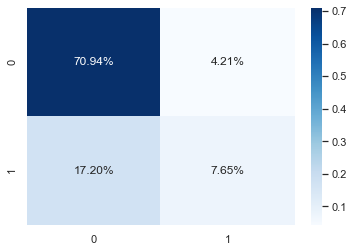

In [83]:
ev.evaluate_log

2) Gaussian Naive Bayes Classifier

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START gaussiannb__priors=None, gaussiannb__var_smoothing=1e-10....
[CV 1/5; 1/3] END gaussiannb__priors=None, gaussiannb__var_smoothing=1e-10; total time=   0.0s
[CV 2/5; 1/3] START gaussiannb__priors=None, gaussiannb__var_smoothing=1e-10....
[CV 2/5; 1/3] END gaussiannb__priors=None, gaussiannb__var_smoothing=1e-10; total time=   0.0s
[CV 3/5; 1/3] START gaussiannb__priors=None, gaussiannb__var_smoothing=1e-10....
[CV 3/5; 1/3] END gaussiannb__priors=None, gaussiannb__var_smoothing=1e-10; total time=   0.0s
[CV 4/5; 1/3] START gaussiannb__priors=None, gaussiannb__var_smoothing=1e-10....
[CV 4/5; 1/3] END gaussiannb__priors=None, gaussiannb__var_smoothing=1e-10; total time=   0.0s
[CV 5/5; 1/3] START gaussiannb__priors=None, gaussiannb__var_smoothing=1e-10....
[CV 5/5; 1/3] END gaussiannb__priors=None, gaussiannb__var_smoothing=1e-10; total time=   0.0s
[CV 1/5; 2/3] START gaussiannb__priors=None, gaussiannb__var

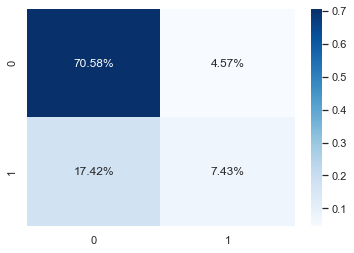

In [84]:
ev.evaluate_gnb